In [1]:
import os
import keras
from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import tensorflow as tf
import skimage.io 
from lime import lime_image
from skimage.segmentation import mark_boundaries


2022-02-25 09:43:56.531319: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-25 09:43:56.531335: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Load Model

In [2]:
inet_model = tf.keras.applications.InceptionV3(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

2022-02-25 09:43:58.087921: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-25 09:43:58.087938: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-25 09:43:58.087949: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (IT081869): /proc/driver/nvidia/version does not exist
2022-02-25 09:43:58.088062: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Get Predictions

[('n07753592', 'banana', 0.4394249),
 ('n07742313', 'Granny_Smith', 0.24754477),
 ('n03482405', 'hamper', 0.19494247),
 ('n07753275', 'pineapple', 0.018014882),
 ('n04204238', 'shopping_basket', 0.01728689)]

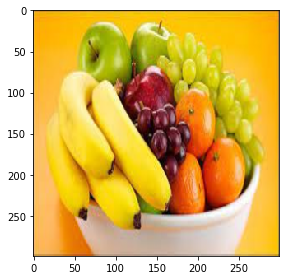

In [3]:
Xi = skimage.io.imread("fruit.jpeg")[:,:,:3]
Xi = skimage.transform.resize(Xi, (299,299)) 
Xi = (Xi - 0.5)*2 #Inception pre-processing
skimage.io.imshow(Xi/2+0.5) # Show image before inception preprocessing
np.random.seed(222)
preds = inet_model.predict(Xi[np.newaxis,:,:,:])
decode_predictions(preds)[0] #Top 5 classes

# Get explainations

In [4]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(Xi.astype('double'), inet_model.predict, top_labels=5, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

# First Class - Bannanas

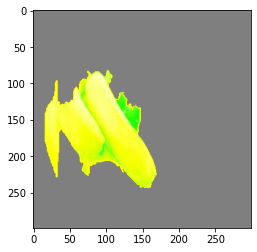

In [5]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

# Second Class - Granny Smith

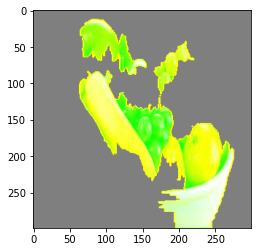

In [10]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[4], positive_only=False, num_features=10, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

# Weights of explaination - Granny Smith

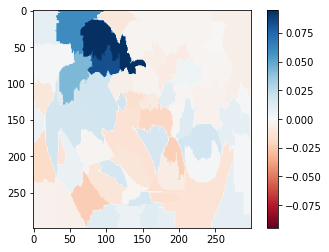

In [7]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[1]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()